In [1]:
import numpy as np
import sbi
from sbi.inference import SNPE
import getdist
from getdist import plots, MCSamples
import sys, pathlib, os, random
import torch
import matplotlib.pyplot as plt
import scipy.stats as stats

2024-11-20 10:51:17.806469: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 10:51:17.949472: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 10:51:17.990332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 10:51:18.263210: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 10:51:20.623667: W tensorflow/compiler/tf2

# Load compressed dv and true paramters

In [14]:
compressed_dv_sims = np.load('../compression_NN/output/compressed_dv_semi_ae_v4.npy')
compressed_dv_labels = np.load('../compression_NN/output/pars_LFI.npy')


compressed_dv_fid  = np.load('../compression_NN/output/dv_compressed_fid_ae_v4.npy')

compressed_dv_fid = compressed_dv_fid.reshape(-1,1).T

In [15]:
compressed_dv_sims.shape, compressed_dv_labels.shape, compressed_dv_fid.shape

((8187, 16), (8187, 3), (1, 16))

# Train sbi-NDE

In [42]:
gd_samples = []


# define compressed data, parameters, and target (compressed)
x0 = compressed_dv_fid
p, l = compressed_dv_sims, compressed_dv_labels


prior = sbi.utils.BoxUniform(low=torch.tensor(np.min(l, axis=0)), \
    high=torch.tensor(np.max(l, axis=0)))
inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\
                model='maf', hidden_features=50, num_transforms=4))
theta, x = torch.tensor(l).float(), torch.tensor(p).float()
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)


samples = posterior.sample((10000,), x=x0)

# gd_samples.append(MCSamples(samples=samples.numpy(), names=['S8'], \
#     labels=[label], ranges={"S8": [np.min(l), np.max(l)]}, label=model))

gd_samples.append(MCSamples(samples=samples.numpy(), names=['Om', 'S8', 'A_IA'], \
    labels=['Om', 'S8', r'A_{IA}'], ranges={"Om": [np.min(l[:, 0]), np.max(l[:, 0])], \
        "S8": [np.min(l[:, 1]), np.max(l[:, 1])], "A_IA": [np.min(l[:, 2]), np.max(l[:, 2])]},\
        label='test'))

/tmp/ipykernel_1818847/3250029904.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  inference = SNPE(prior=prior, density_estimator=sbi.utils.posterior_nn(\


 Neural network successfully converged after 76 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


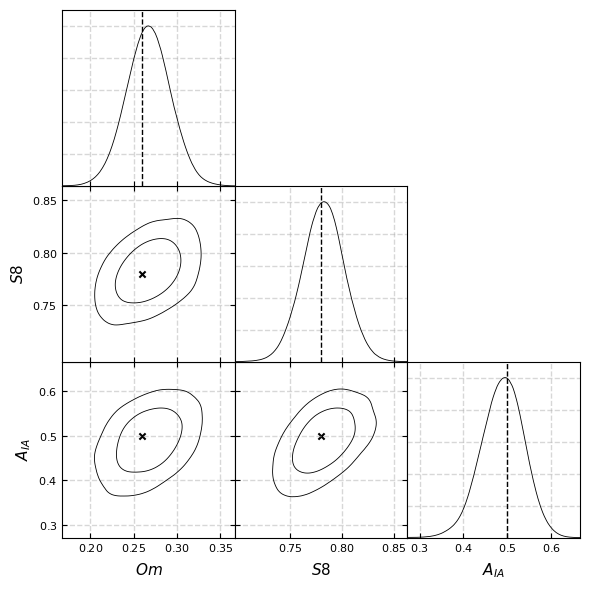

In [43]:
%matplotlib inline 

g = plots.get_subplot_plotter()
g.triangle_plot(gd_samples[0], filled=False)

true = [0.26, 0.78, 0.5]

# add truth values to get subplot
for i in range(3):
    for j in range(3):
        if j > i:
            continue
        ax = g.subplots[i, j]
        if i == j:
            ax.axvline(true[i], color="black", ls="--", lw=1)
        else:
            ax.scatter(true[j], true[i], color="black", marker="x", s=20) 
        ax.grid(True, ls="--", lw=1, alpha=0.5)

In [52]:
cov_mat = gd_samples[0].getCovMat().matrix

In [54]:
cov_mat

array([[0.00064534, 0.00020583, 0.00046503],
       [0.00020583, 0.00041214, 0.00048888],
       [0.00046503, 0.00048888, 0.00237553]])

In [56]:
FOM_1= 1./np.sqrt(np.linalg.det(cov_mat[0:2, 0:2]))

print(FOM_1)

2114.742384994057
